# Tweening (Temporal gap-filling)
This notebook gives an example of hourly surface land surface temperature prediction using the IBM granite-geospatial-surface-urban-heat model. The intension of this notebook is to demonstrate the model's utility in generating land surface temperature predictions between satellite observations (8-16 days) at the hourly frequence. 


The steps in the process are:

1. Produce an HLS temporal dataset using the most recent HLS L30 observation. 
2. Stack the HLS L30 data from step 1. with hourly ERA5-Land T2m.

Refer to: [tweening_data_preparation](./5_tweening_data_preparation.ipynb), for steps to produce the tweening dataset described above.

3. Execute inferencing on the Stacked hourly inputs from step 2.
4. Compute the geospatial mean:
     1. per hourly prediction
     2. per hourly ERA5-Land T2m
     3. per hourly ERA5-Land Skin Termperature
5. Plot an animation of the predicted LST

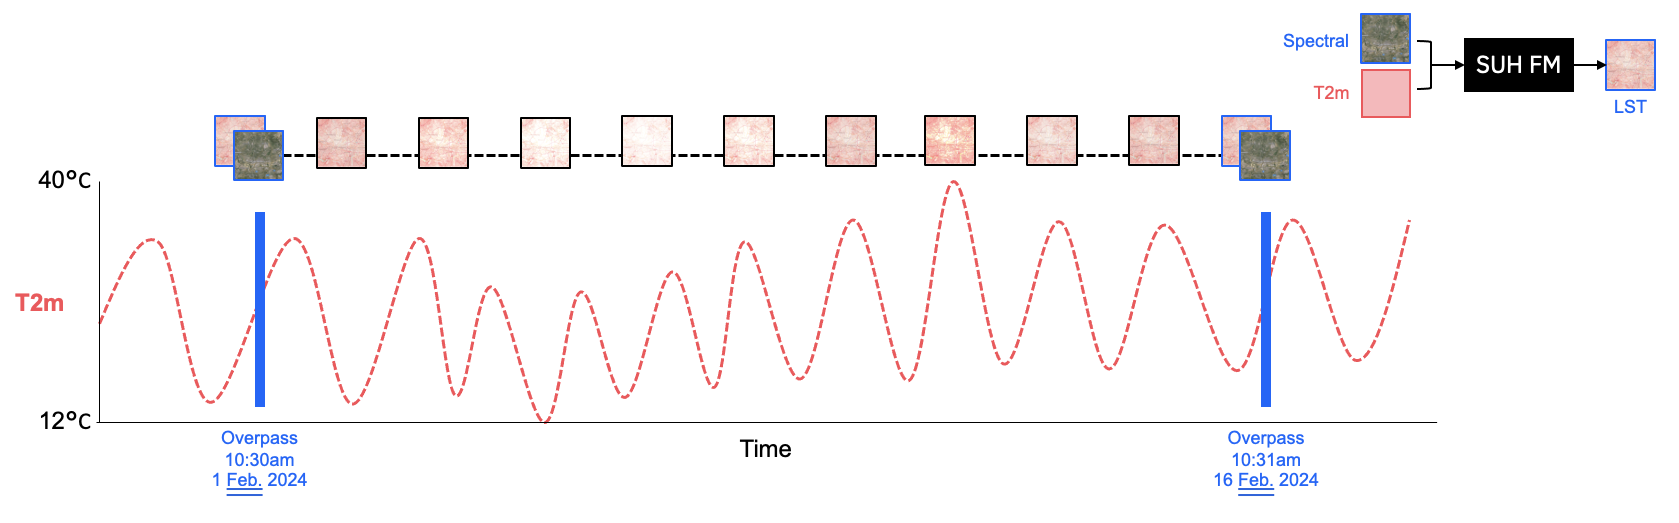

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import cm
import glob
import os
import rasterio
import xarray as xr
import rioxarray as rx
import numpy as np
import shutil
import yaml
import pandas as pd
import pylab as plb
from pathlib import Path
from collections import Counter
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
import matplotlib as mpl
from huggingface_hub import hf_hub_download
mpl.rcParams['agg.path.chunksize'] = 10000
import subprocess
import datetime
from datetime import datetime as dt
import rasterio as rs
from matplotlib.animation import FuncAnimation
import matplotlib
from utils.plotting import stack_rgb, load_lst, plot_rgb_and_lst, analyze_rasters
from IPython.display import Image, display


#matplotlib.use('Agg')  
#import dask
import logging
logging.getLogger("lightning").setLevel(logging.ERROR)

In [ ]:
# Download dataset from Zenodo
dataset_path = Path("../data/granite-geospatial-land-surface-temperature-tweening-dataset.tar.gz")
!wget "https://zenodo.org/records/14034636/files/granite-geospatial-land-surface-temperature-tweening-dataset.tar.gz?download=1" -O {str(dataset_path)}

# Download checkpoints from Hugging Face
#os.makedirs('./checkpoints', exist_ok=True)
ckpt_path = hf_hub_download(repo_id="ibm-granite/granite-geospatial-land-surface-temperature", filename="LST_model.ckpt", local_dir="../")

# Download config file
config_path = hf_hub_download(repo_id="ibm-granite/granite-geospatial-land-surface-temperature", filename="config_full_tile.yaml", local_dir="../")

--2024-11-05 08:11:23--  https://zenodo.org/records/14034636/files/granite-geospatial-land-surface-temperature-tweening-dataset.tar.gz?download=1
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.98.238, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13453959863 (13G) [application/octet-stream]
Saving to: ‘../data/granite-geospatial-land-surface-temperature-tweening-dataset.tar.gz’

       ../data/gran   2%[                    ] 261.84M   221KB/s    eta 13h 17m

In [ ]:
# Unpack compressed files
target_directory = '../data/'
!tar -xf {dataset_path} --directory {target_directory}

In [ ]:
city = "Johannesburg"
season = "winter"
inputs_path = os.path.join("../data/Tweening_inputs/dccstor/sarl_data/v2-5-data/granite-geospatial-land-surface-temperature-tweening-dataset/inputs", city, season)

inference_path = "../data/Tweening_predictions"  
os.makedirs(inference_path, exist_ok=True) 

## Execute infencing on stacked hourly inputs

In [ ]:
conf = yaml.safe_load(Path(config_path).read_text())
data_bands = "[" + ",".join([str(x) for x in conf['data']['init_args']['output_bands']]) + "]"
inputs_path = inputs_path  
assert os.path.isdir(inputs_path), f"Directory not found: {inputs_path}"
inference_path = inference_path
os.makedirs(inference_path, exist_ok=True)
run_str = f"terratorch predict -c {config_path} --ckpt_path {ckpt_path} --predict_output_dir {inference_path} --data.init_args.predict_data_root {inputs_path} --data.init_args.predict_dataset_bands {data_bands}"

print(f"Running inference:")
print(run_str)

#If the below block of code where subprocess.call does not work, comment it out and use the run string and do the inferencing via the CLI.
subprocess.call(['terratorch', 'predict', '-c', config_path,
                 '--ckpt_path', ckpt_path, 
                 '--predict_output_dir', inference_path, 
                 '--data.init_args.predict_data_root', inputs_path, 
                 '--data.init_args.predict_dataset_bands', data_bands])
print("---------- Complete ----------")
print("========== DONE ==========")

Running inference:
terratorch predict -c ./configs/config_full_tile.yaml --ckpt_path ./checkpoints/LST_model.ckpt --predict_output_dir ./Tweening_predictions --data.init_args.predict_data_root ./Tweening_inputs --data.init_args.predict_dataset_bands [BLUE,GREEN,RED,NIR_NARROW,SWIR_1,SWIR_2,7]


/u/cmahlasi/miniforge3/envs/GDN/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
Seed set to 0
No pretrained configuration specified for prithvi_swin_L model. Using a default. Please add a config to the model pretrained_cfg registry or pass explicitly.
/u/cmahlasi/miniforge3/envs/GDN/lib/python3.10/site-packages/lightning/pytorch/cli.py:654: `PixelwiseRegressionTask.configure_optimizers` will be overridden by `MyLightningCLI.configure_optimizers`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at ./checkpoints/LST_model.ckpt
/u/cmahlasi/miniforge3/envs/GDN/lib/python3.10/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `t

Predicting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/72 0:00:00 • -:--:-- 0.00it/s 

[W1105 03:59:19.113847809 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


Predicting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72/72 0:16:23 • 0:00:00 0.07it/s it/s it/s 
---------- Complete ----------
========== DONE ==========


## Calculate hourly means

### Predictions

In [23]:
def create_data(path):
    
    tif_fps = sorted(glob.glob(os.path.join(path, '*.tif')))
    dataset_name = []

    for tfs in tif_fps:
        print(f"Processing file: {tfs}")
        ds = xr.open_dataset(tfs)
        date = (os.path.basename(tfs).split(".")[2:4])
        date = ''.join(date)
        print(date)
        ds = ds.assign_coords(time=date)
        dataset_name.append(ds)
    dataset_name = xr.concat(dataset_name, dim='time')
    return dataset_name

In [24]:
pred = create_data(inference_path)
pred['time'] = pd.DatetimeIndex(pred['time'].values)

Processing file: ./Tweening_predictions/johannesburg_zaf.T35JPM.20230712.T000000.stacked_inputs_pred.tif


20230712T000000
Processing file: ./Tweening_predictions/johannesburg_zaf.T35JPM.20230712.T010000.stacked_inputs_pred.tif
20230712T010000
Processing file: ./Tweening_predictions/johannesburg_zaf.T35JPM.20230712.T020000.stacked_inputs_pred.tif
20230712T020000
Processing file: ./Tweening_predictions/johannesburg_zaf.T35JPM.20230712.T030000.stacked_inputs_pred.tif
20230712T030000
Processing file: ./Tweening_predictions/johannesburg_zaf.T35JPM.20230712.T040000.stacked_inputs_pred.tif
20230712T040000
Processing file: ./Tweening_predictions/johannesburg_zaf.T35JPM.20230712.T050000.stacked_inputs_pred.tif
20230712T050000
Processing file: ./Tweening_predictions/johannesburg_zaf.T35JPM.20230712.T060000.stacked_inputs_pred.tif
20230712T060000
Processing file: ./Tweening_predictions/johannesburg_zaf.T35JPM.20230712.T070000.stacked_inputs_pred.tif
20230712T070000
Processing file: ./Tweening_predictions/johannesburg_zaf.T35JPM.20230712.T080000.stacked_inputs_pred.tif
20230712T080000
Processing file:

In [25]:
date_start = "2023-07-12"
date_end = "2023-07-14"
timestamps = pd.date_range(start=date_start, periods=len(pred.time), freq='h')  # Adjust the start date and frequency based on tweening inputs lenght
#timestamps

In [27]:
pred_mean = pred.mean(dim=['x','y'])
pred_mean = pred_mean.squeeze('band')
pred_mean

<xarray.Dataset> Size: 880B
Dimensions:      (time: 72)
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 576B 2023-07-12 ... 2023-07-14T23:00:00
Data variables:
    band_data    (time) float32 288B 7.17 6.13 5.091 4.259 ... 10.73 9.763 8.93

### ERA5-Land T2m and Skin Temperature 

In [28]:
def read_raster_data(input_pattern, band_index, timestamps):
    raster_files = sorted(glob.glob(input_pattern))
    data_arrays = []
    
    for i, raster_path in enumerate(raster_files):
        try:
            with rasterio.open(raster_path) as src:
                raster = src.read(band_index)  # Read the specified band
                data_array = xr.DataArray(
                    data=raster,
                    dims=["y", "x"],
                    coords={"y": range(raster.shape[0]), "x": range(raster.shape[1])}
                )
                data_arrays.append(data_array.expand_dims(time=[timestamps[i]]))  # Add time dimension
        except Exception as e:
            print(f"Error reading {raster_path}: {e}")

    return xr.concat(data_arrays, dim='time')
 
t2m_merged = read_raster_data(os.path.join(inputs_path, '*_inputs.tif'), band_index=7, timestamps=timestamps)
st_merged = read_raster_data(os.path.join(inputs_path, '*_inputs.tif'), band_index=11, timestamps=timestamps)


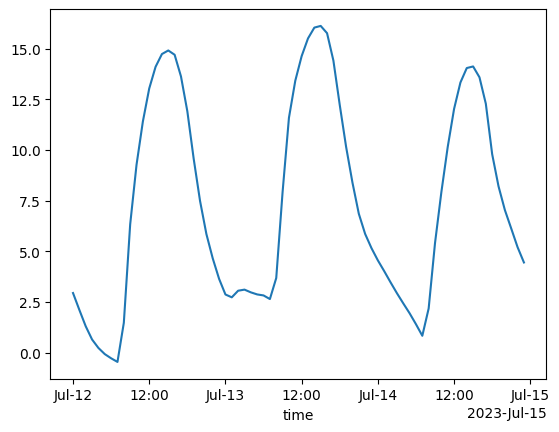

In [30]:
era5_land_t2m_subset = t2m_merged.sel(time=slice(date_start, date_end))
era5_land_t2m_subset_mean = era5_land_t2m_subset.mean(dim=['y', 'x'])
era5_land_t2m_subset_mean = era5_land_t2m_subset_mean 
era5_land_t2m_subset_mean.plot()


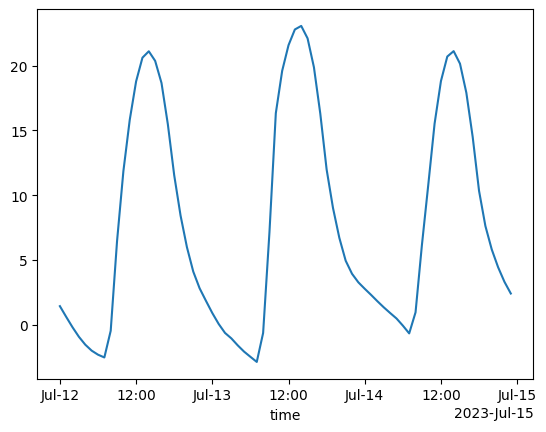

In [31]:
era5_land_st_subset = st_merged.sel(time=slice(date_start, date_end))
era5_land_st_subset_mean = era5_land_st_subset.mean(dim=['y', 'x'])
era5_land_st_subset_mean = era5_land_st_subset_mean 
era5_land_st_subset_mean.plot()

### LST Acquisition Mean and Std-Dev

In [ ]:
lst_acq_path = "../data/Tweening_inputs/dccstor/sarl_data/v2-5-data/granite-geospatial-land-surface-temperature-tweening-dataset/targets/Johannesburg/winter/johannesburg_zaf.T35JPM.20230712.T080131.lst.tif" # path to  calculated (not predicted by model) LST
lst_acq = xr.open_dataset(lst_acq_path)
date = (os.path.basename(lst_acq_path).split(".")[2:4])
date = ''.join(date)
local_shift = +2 #change based on the city's local time 
utm_time = date.split("T")[1]
local_time = int(utm_time) + (local_shift * 10000)
local_date = date.split("T")[0] + "T" + str(local_time)
print(local_date)
lst_acq = lst_acq.assign_coords(time=local_date)
lst_acq['time'] = pd.to_datetime(lst_acq['time'].values)
lst_acq

20230712T100131


<xarray.Dataset> Size: 12MB
Dimensions:      (band: 1, x: 1184, y: 1316)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 9kB 6e+05 6e+05 6.001e+05 ... 6.355e+05 6.355e+05
  * y            (y) float64 11kB -2.87e+06 -2.87e+06 ... -2.91e+06 -2.91e+06
    spatial_ref  int64 8B ...
    time         datetime64[ns] 8B 2023-07-12T10:01:31
Data variables:
    band_data    (band, y, x) float64 12MB ...

In [34]:
lst_acq_mean = lst_acq.mean(dim=['x','y'])
lst_acq_mean

<xarray.Dataset> Size: 32B
Dimensions:      (band: 1)
Coordinates:
  * band         (band) int64 8B 1
    spatial_ref  int64 8B ...
    time         datetime64[ns] 8B 2023-07-12T10:01:31
Data variables:
    band_data    (band) float64 8B 12.65

In [35]:
lst_acq_std = lst_acq.std(dim=['x','y'])
lst_acq_std

<xarray.Dataset> Size: 32B
Dimensions:      (band: 1)
Coordinates:
  * band         (band) int64 8B 1
    spatial_ref  int64 8B ...
    time         datetime64[ns] 8B 2023-07-12T10:01:31
Data variables:
    band_data    (band) float64 8B 1.666

## Generate plot of the mean values to guage correclation between the predictions and the ERA5-Land hourly values

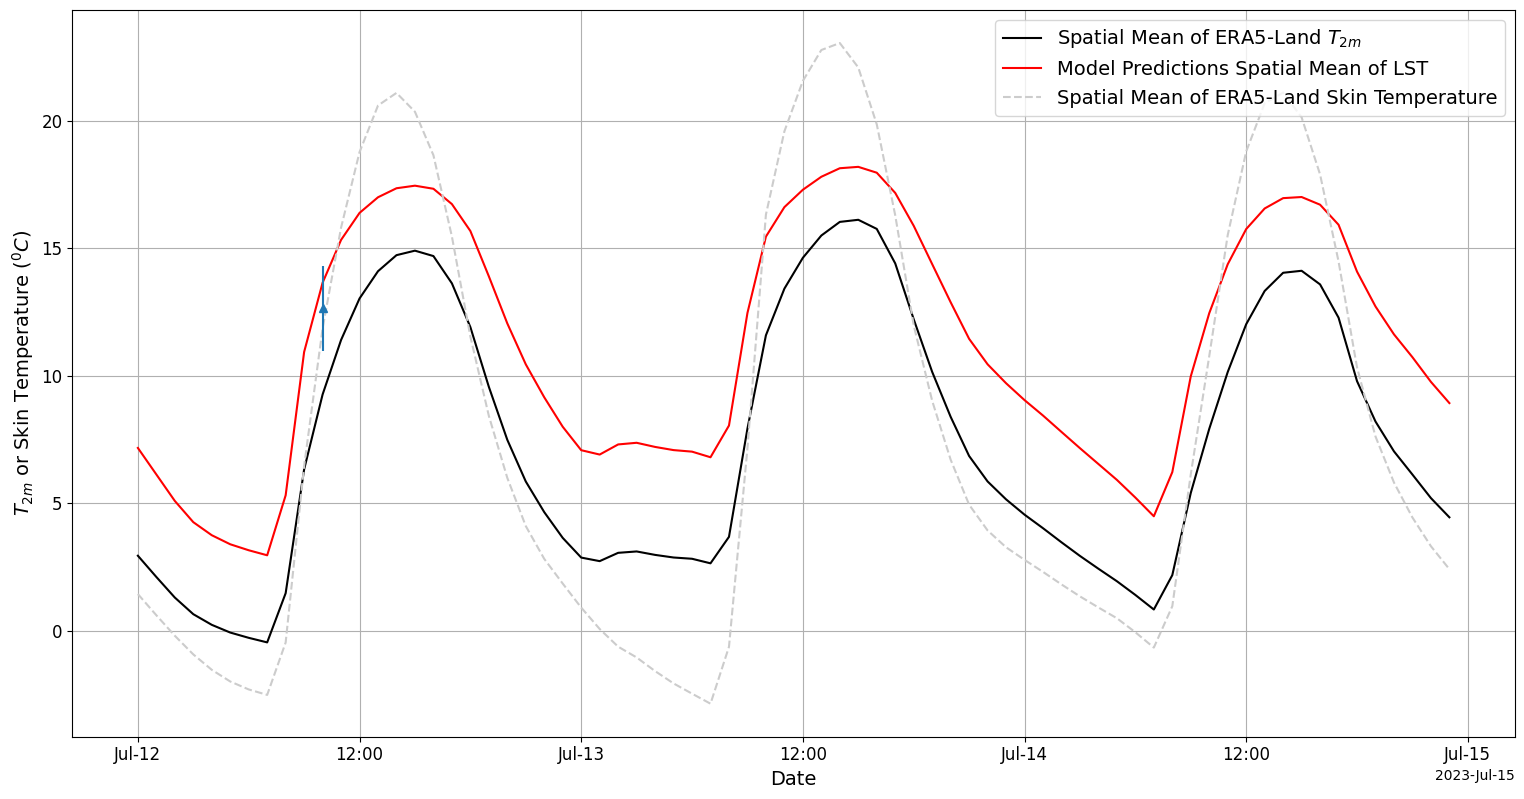

In [36]:
plt.figure(figsize=(15,8))
era5_land_t2m_subset_mean.plot(label=r'Spatial Mean of ERA5-Land $T_{2m}$', color ='k')
pred_mean['band_data'].plot(label=r'Model Predictions Spatial Mean of LST', color = 'r')
era5_land_st_subset_mean.plot(label=r'Spatial Mean of ERA5-Land Skin Temperature', color = '0.8', linestyle='--')
plt.errorbar(lst_acq['time'], lst_acq_mean['band_data'], lst_acq_std['band_data'], linestyle='None', marker='^')
plt.tight_layout()
plt.grid()
plt.legend(fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel(r'$T_{2m}$ or Skin Temperature ($^{0}C$)', fontsize=14)
plt.title(None)
plt.show()

## Generate and save animation of the predicted 3-day LST 

In [40]:
#Calculate the temporal min and max of the predictions for static colourbar
minmax = analyze_rasters(inference_path)  

Raster data shape: (72, 1316, 1184)
5th Percentile (Global Minimum Value): 3.684825897216797
95th Percentile (Global Maximum Value): 18.468156814575195


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-8.846461..15.89165].


Animation saved as Johannesburg_winter_lst_animation.gif


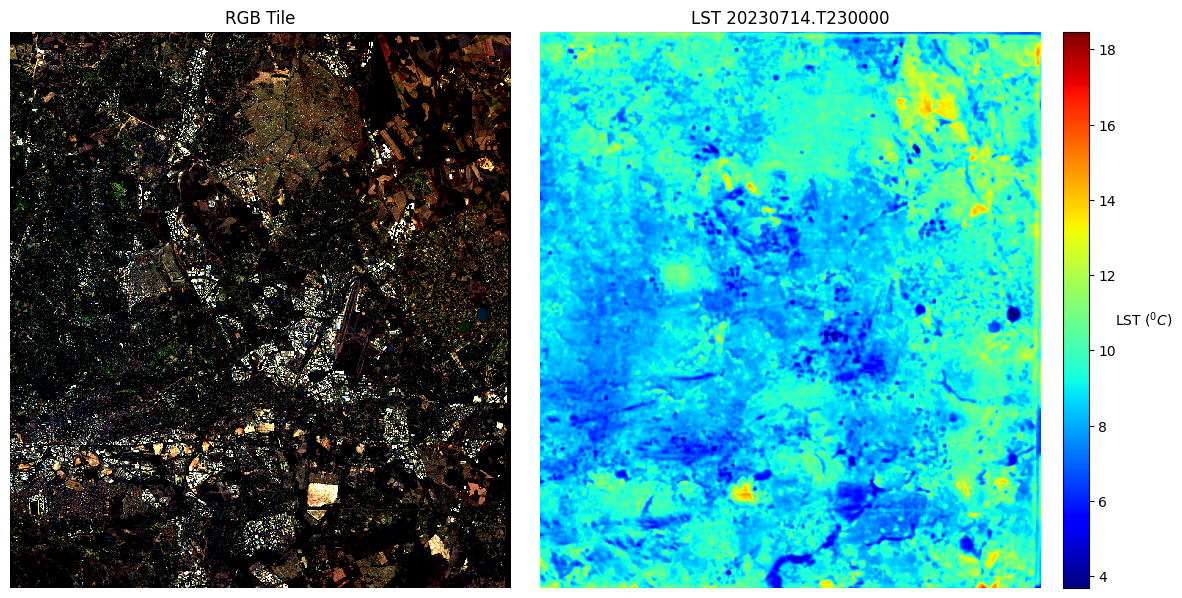

In [41]:
# Load inputs files 
input_files = glob.glob(os.path.join(inputs_path, "*.tif"))
input_file = sorted(input_files)[1] if input_files else None

# Load predicted files 
pred_files = glob.glob(os.path.join(inference_path, "*_pred.tif"))
pred_files = sorted(pred_files)  # Sort by date

# Define the output animation filename 
output_filename = 'Johannesburg_winter_lst_animation.gif'  # change animation 

# plot and save the animation
plot_rgb_and_lst(input_file, pred_files, minmax, output_file=output_filename)

# Display the saved animation
#display(Image(filename=output_filename))



In [ ]:
#Pre-computed animation of the cith of Johannesburg summer tweening. Run this cell to visualise/play the animation.
display(Image(data=open('./assets/images/Johannesburg_summer_lst_animation.gif','rb').read(), format='gif'))

In [ ]:
#Pre-computed animation of the cith of Johannesburg winter tweening. Run this cell to visualise/play the animation.
display(Image(data=open('./assets/images/Johannesburg_winter_lst_animation.gif','rb').read(), format='gif'))

That is how the Tweening works. You can now use the data we provided for Baltimore to implement Tweening on another city. You can also use [tweening_data_preparation](./5_tweening_data_preparation.ipynb) to prepare your own Tweening dataset for a city of your choice.